In [ ]:
import pandas as pd
import re
import logging
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [ ]:
def setup_logger():
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        handlers=[
            logging.FileHandler(f"house_data_processing_{datetime.now().strftime('%Y%m%d')}.log"),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)


def extract_raw_data(file_path: str, logger) -> list[dict]:
    try:
        df = pd.read_excel(file_path)
        file_name = os.path.basename(file_path)
        data_type = "二手房" if "esf" in file_name else "租房"
        area_match = re.search(r"(esf|zu)_(.*?)_data", file_name)
        location = (
            area_match.group(2)
            .replace("huailai", "怀来")
            .replace("qiaoxi", "桥西")
            .replace("xiahuayuan", "下花园")
            .replace("zhangbei", "张北")
            if area_match
            else "未知区域"
        )

        raw_data = []
        for idx, row in df.iterrows():
            area_str = str(row.get("面积", row.get("房屋面积", row.get("面积(㎡)", "")))).strip()
            area_num = re.search(r"(\d+(\.\d+)?)", area_str)
            area = float(area_num.group(1)) if area_num else None

            if data_type == "二手房":
                price_str = str(row.get("总价", row.get("总价(万)", ""))).strip()
                price_match = re.search(r"(\d+(\.\d+)?)\s*([万千元]?)", price_str)
                price_val = float(price_match.group(1)) if price_match else None
                price_unit = price_match.group(3) if (price_match and price_match.group(3)) else "元"
                raw_data.append({
                    "类型": "二手房",
                    "位置": location,
                    "面积(㎡)": area,
                    "原始数值": price_val,
                    "原始单位": price_unit,
                    "行号": idx + 1,
                    "文件": file_name
                })
            else:
                rent_str = str(row.get("租金", row.get("月租金", row.get("租金(元/月)", "")))).strip()
                rent_match = re.search(r"(\d+(\.\d+)?)\s*([万千]?)/?月?", rent_str)
                rent_val = float(rent_match.group(1)) if rent_match else None
                rent_unit = rent_match.group(3) if (rent_match and rent_match.group(3)) else "元"
                raw_data.append({
                    "类型": "租房",
                    "位置": location,
                    "面积(㎡)": area,
                    "原始数值": rent_val,
                    "原始单位": rent_unit,
                    "行号": idx + 1,
                    "文件": file_name
                })
        return raw_data
    except Exception as e:
        logger.error(f"提取文件 {file_path} 数据失败：{str(e)}")
        return []


def unify_units(raw_df: pd.DataFrame, logger) -> tuple[pd.DataFrame, pd.DataFrame]:
    esf_raw = raw_df[raw_df["类型"] == "二手房"].copy()
    zu_raw = raw_df[raw_df["类型"] == "租房"].copy()

    esf_raw.loc[esf_raw["位置"].isin(["怀来", "桥西"]), "换算后数值(元)"] = esf_raw["原始数值"] * 10000
    esf_raw.loc[esf_raw["位置"].isin(["怀来", "桥西"]), "换算说明"] = "怀来/桥西强制×1万"
    mask_other = ~esf_raw["位置"].isin(["怀来", "桥西"])
    esf_raw.loc[mask_other & (esf_raw["原始单位"] == "万"), "换算后数值(元)"] = esf_raw["原始数值"] * 10000
    esf_raw.loc[mask_other & (esf_raw["原始单位"].isin(["元", ""])), "换算后数值(元)"] = esf_raw["原始数值"]

    zu_raw.loc[zu_raw["原始单位"] == "万", "换算后数值(元/月)"] = zu_raw["原始数值"] * 10000
    zu_raw.loc[zu_raw["原始单位"] == "千", "换算后数值(元/月)"] = zu_raw["原始数值"] * 1000
    zu_raw.loc[zu_raw["原始单位"].isin(["元", ""]), "换算后数值(元/月)"] = zu_raw["原始数值"]

    esf_clean = esf_raw.dropna(subset=["面积(㎡)", "换算后数值(元)"]).copy()
    zu_clean = zu_raw.dropna(subset=["面积(㎡)", "换算后数值(元/月)"]).copy()
    esf_clean["单价(元/㎡)"] = round(esf_clean["换算后数值(元)"] / esf_clean["面积(㎡)"], 2)
    zu_clean["单价(元/月/㎡)"] = round(zu_clean["换算后数值(元/月)"] / zu_clean["面积(㎡)"], 2)

    logger.info(f"数据清洗完成：二手房{len(esf_clean)}条，租房{len(zu_clean)}条")
    return esf_clean, zu_clean


def generate_data_files(logger):
    data_dir = "."
    all_raw_data = []

    for file_name in os.listdir(data_dir):
        if not file_name.endswith((".xlsx", ".xls")):
            continue
        file_path = os.path.join(data_dir, file_name)
        logger.info(f"处理文件：{file_path}")
        all_raw_data.extend(extract_raw_data(file_path, logger))

    if not all_raw_data:
        logger.error("未找到数据文件！请将含'esf'（二手房）和'zu'（租房）的Excel放在当前目录")
        raise FileNotFoundError("无有效数据文件")

    raw_df = pd.DataFrame(all_raw_data)
    esf_clean, zu_clean = unify_units(raw_df, logger)
    
    esf_final = esf_clean[["位置", "面积(㎡)", "单价(元/㎡)"]]
    zu_final = zu_clean[["位置", "面积(㎡)", "单价(元/月/㎡)"]]
    esf_final.to_excel("二手房数据（统一单位后）.xlsx", index=False)
    zu_final.to_excel("租房数据（统一单位后）.xlsx", index=False)
    logger.info("生成建模数据文件完成")



In [ ]:
def load_model_data():
    try:
        price_data = pd.read_excel("二手房数据（统一单位后）.xlsx")
        rent_data = pd.read_excel("租房数据（统一单位后）.xlsx")
    except FileNotFoundError as e:
        raise FileNotFoundError(f"建模数据缺失：{e}")

    price_data.columns = ["location", "area", "price_per_m2"]
    rent_data.columns = ["location", "area", "rent_per_m2"]
    return price_data.dropna(), rent_data.dropna()


def create_features(data):
    df = data.copy()
    df["area_sq"] = df["area"] **2
    return df


def build_basic_model():
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(drop="first"), ["location"]),
            ("num", "passthrough", ["area"])
        ])
    return Pipeline(steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())])


def build_extended_model():
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(drop="first"), ["location"]),
            ("num", "passthrough", ["area", "area_sq"])
        ])
    return Pipeline(steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())])


def train_model(X, y, model, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - 测试集R²：{r2:.4f}")
    return model, r2


def calculate_and_plot_ratio(price_pred, price_locations, rent_pred, rent_locations, title, fig_name):
    """修正：按街区计算平均预测价格和租金，再求租售比"""
    # 1. 构建房价预测结果DataFrame并按街区取平均
    price_df = pd.DataFrame({
        "location": price_locations,
        "price_pred": price_pred
    })
    price_mean = price_df.groupby("location")["price_pred"].mean().reset_index()
    price_mean.rename(columns={"price_pred": "avg_price_pred"}, inplace=True)

    # 2. 构建租金预测结果DataFrame并按街区取平均
    rent_df = pd.DataFrame({
        "location": rent_locations,
        "rent_pred": rent_pred
    })
    rent_mean = rent_df.groupby("location")["rent_pred"].mean().reset_index()
    rent_mean.rename(columns={"rent_pred": "avg_rent_pred"}, inplace=True)

    # 3. 合并并计算租售比（确保街区匹配）
    ratio_df = pd.merge(price_mean, rent_mean, on="location", how="inner")
    ratio_df["price_to_rent"] = ratio_df["avg_price_pred"] / ratio_df["avg_rent_pred"]

    # 4. 绘图
    font = FontProperties(fname="C:/Windows/Fonts/simhei.ttf", size=12)
    plt.figure(figsize=(10, 6))
    bars = plt.bar(ratio_df["location"], ratio_df["price_to_rent"], color='skyblue')

    plt.title(title, fontproperties=font, fontsize=14)
    plt.xlabel('街区', fontproperties=font, fontsize=12)
    plt.ylabel('租售比（平均房价÷平均租金）', fontproperties=font, fontsize=12)
    plt.xticks(fontproperties=font)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.2f}', 
            ha='center', 
            fontsize=10,
            fontproperties=font
        )

    plt.tight_layout()
    plt.savefig(f"{fig_name}.png", dpi=300)
    plt.show()
    return ratio_df

In [ ]:
def main():
    # 步骤1：数据处理
    logger = setup_logger()
    print("===== 第一步：数据处理 =====")
    generate_data_files(logger)

    # 步骤2：加载数据
    print("\n===== 第二步：加载建模数据 =====")
    price_data, rent_data = load_model_data()
    print(f"房价样本：{len(price_data)}条，租金样本：{len(rent_data)}条")

    # 步骤3：训练基础模型
    print("\n===== 第三步：训练基础模型 =====")
    X_price_basic = price_data[["location", "area"]]
    model1, r2_m1 = train_model(
        X_price_basic, price_data["price_per_m2"], 
        build_basic_model(), "Model 1（房价基础模型）"
    )
    X_rent_basic = rent_data[["location", "area"]]
    model2, r2_m2 = train_model(
        X_rent_basic, rent_data["rent_per_m2"], 
        build_basic_model(), "Model 2（租金基础模型）"
    )

    # 步骤4：训练扩展模型
    print("\n===== 第四步：训练扩展模型 =====")
    price_extended = create_features(price_data)
    rent_extended = create_features(rent_data)
    
    X_price_ext = price_extended[["location", "area", "area_sq"]]
    model1_plus, r2_m1p = train_model(
        X_price_ext, price_data["price_per_m2"], 
        build_extended_model(), "Model 1+（房价扩展模型）"
    )
    X_rent_ext = rent_extended[["location", "area", "area_sq"]]
    model2_plus, r2_m2p = train_model(
        X_rent_ext, rent_data["rent_per_m2"], 
        build_extended_model(), "Model 2+（租金扩展模型）"
    )

    # 步骤5：模型对比
    print("\n===== 第五步：模型R²对比 =====")
    print(f"房价模型：基础模型{r2_m1:.4f} vs 扩展模型{r2_m1p:.4f}")
    print(f"租金模型：基础模型{r2_m2:.4f} vs 扩展模型{r2_m2p:.4f}")
    print("结论：扩展模型R²更高，因包含非线性和交互项")

    # 步骤6：基础模型租售比（按街区平均）
    print("\n===== 第六步：基础模型租售比 =====")
    price_pred_basic = model1.predict(X_price_basic)
    rent_pred_basic = model2.predict(X_rent_basic)
    calculate_and_plot_ratio(
        price_pred=price_pred_basic,
        price_locations=price_data["location"],
        rent_pred=rent_pred_basic,
        rent_locations=rent_data["location"],
        title="Figure B：基础模型预测的各街区租售比（平均）",
        fig_name="figure_b_basic"
    )

    # 步骤7：扩展模型租售比（按街区平均）
    print("\n===== 第七步：扩展模型租售比 =====")
    price_pred_ext = model1_plus.predict(X_price_ext)
    rent_pred_ext = model2_plus.predict(X_rent_ext)
    calculate_and_plot_ratio(
        price_pred=price_pred_ext,
        price_locations=price_data["location"],
        rent_pred=rent_pred_ext,
        rent_locations=rent_data["location"],
        title="Figure C：扩展模型预测的各街区租售比（平均）",
        fig_name="figure_c_extended"
    )

    print("\n===== 完成 =====")


if __name__ == "__main__":
    main()

2025-10-16 19:21:31,373 - INFO - 处理文件：.\all_universities.xlsx
2025-10-16 19:21:31,425 - INFO - 处理文件：.\fund_info.xlsx
2025-10-16 19:21:31,442 - INFO - 处理文件：.\hebei_esf_huailai_data.xlsx


===== 第一步：数据处理 =====


2025-10-16 19:21:31,826 - INFO - 处理文件：.\hebei_esf_qiaoxi_data.xlsx
2025-10-16 19:21:32,159 - INFO - 处理文件：.\hebei_esf_xiahuayuan_data.xlsx
2025-10-16 19:21:32,368 - INFO - 处理文件：.\hebei_esf_zhangbei_data.xlsx
2025-10-16 19:21:32,484 - INFO - 处理文件：.\hebei_zu_huailai_data.xlsx
2025-10-16 19:21:32,525 - INFO - 处理文件：.\hebei_zu_qiaoxi_data.xlsx
2025-10-16 19:21:32,736 - INFO - 处理文件：.\hebei_zu_xiahuayuan_data.xlsx
2025-10-16 19:21:32,838 - INFO - 处理文件：.\hebei_zu_zhangbei_data.xlsx
2025-10-16 19:21:32,941 - INFO - 处理文件：.\list.xlsx
2025-10-16 19:21:33,058 - INFO - 处理文件：.\research_fields_journals_skills_final.xlsx
2025-10-16 19:21:33,077 - INFO - 处理文件：.\research_fields_top_journals.xlsx
2025-10-16 19:21:33,095 - INFO - 处理文件：.\research_fields_top_journals_final.xlsx
2025-10-16 19:21:33,116 - INFO - 处理文件：.\universiti.xlsx
2025-10-16 19:21:33,138 - INFO - 处理文件：.\二手房_price_right全信息.xlsx
2025-10-16 19:21:33,152 - INFO - 处理文件：.\二手房数据_Edge.xlsx
2025-10-16 19:21:33,264 - INFO - 处理文件：.\二手房数据_精准定位.xlsx
202


===== 第二步：加载建模数据 =====
房价样本：3010条，租金样本：1190条

===== 第三步：训练基础模型 =====
Model 1（房价基础模型） - 测试集R²：0.0277
Model 2（租金基础模型） - 测试集R²：0.1522

===== 第四步：训练扩展模型 =====
Model 1+（房价扩展模型） - 测试集R²：0.0421
Model 2+（租金扩展模型） - 测试集R²：0.2904

===== 第五步：模型R²对比 =====
房价模型：基础模型0.0277 vs 扩展模型0.0421
租金模型：基础模型0.1522 vs 扩展模型0.2904
结论：扩展模型R²更高，因包含非线性和交互项

===== 第六步：基础模型租售比 =====


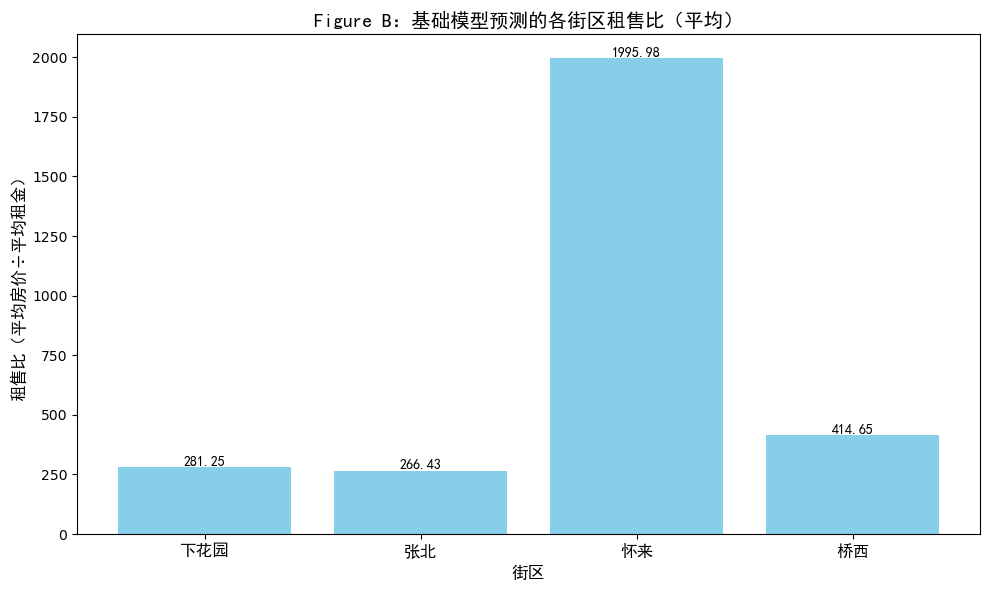


===== 第七步：扩展模型租售比 =====


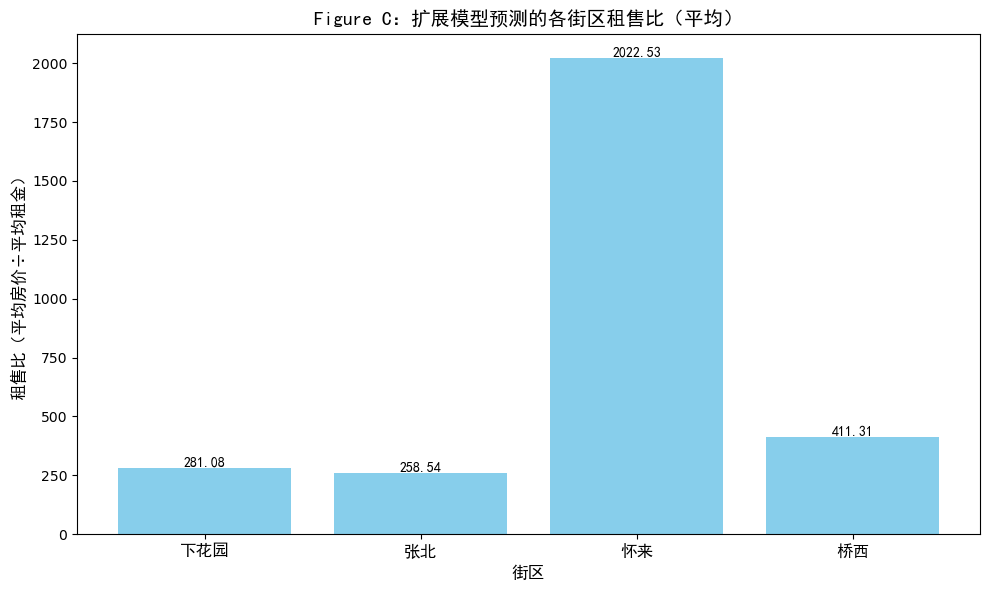


===== 完成 =====


In [5]:



# ====================== 1. 数据处理模块 ======================
def setup_logger():
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        handlers=[
            logging.FileHandler(f"house_data_processing_{datetime.now().strftime('%Y%m%d')}.log"),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)


def extract_raw_data(file_path: str, logger) -> list[dict]:
    try:
        df = pd.read_excel(file_path)
        file_name = os.path.basename(file_path)
        data_type = "二手房" if "esf" in file_name else "租房"
        area_match = re.search(r"(esf|zu)_(.*?)_data", file_name)
        location = (
            area_match.group(2)
            .replace("huailai", "怀来")
            .replace("qiaoxi", "桥西")
            .replace("xiahuayuan", "下花园")
            .replace("zhangbei", "张北")
            if area_match
            else "未知区域"
        )

        raw_data = []
        for idx, row in df.iterrows():
            area_str = str(row.get("面积", row.get("房屋面积", row.get("面积(㎡)", "")))).strip()
            area_num = re.search(r"(\d+(\.\d+)?)", area_str)
            area = float(area_num.group(1)) if area_num else None

            if data_type == "二手房":
                price_str = str(row.get("总价", row.get("总价(万)", ""))).strip()
                price_match = re.search(r"(\d+(\.\d+)?)\s*([万千元]?)", price_str)
                price_val = float(price_match.group(1)) if price_match else None
                price_unit = price_match.group(3) if (price_match and price_match.group(3)) else "元"
                raw_data.append({
                    "类型": "二手房",
                    "位置": location,
                    "面积(㎡)": area,
                    "原始数值": price_val,
                    "原始单位": price_unit,
                    "行号": idx + 1,
                    "文件": file_name
                })
            else:
                rent_str = str(row.get("租金", row.get("月租金", row.get("租金(元/月)", "")))).strip()
                rent_match = re.search(r"(\d+(\.\d+)?)\s*([万千]?)/?月?", rent_str)
                rent_val = float(rent_match.group(1)) if rent_match else None
                rent_unit = rent_match.group(3) if (rent_match and rent_match.group(3)) else "元"
                raw_data.append({
                    "类型": "租房",
                    "位置": location,
                    "面积(㎡)": area,
                    "原始数值": rent_val,
                    "原始单位": rent_unit,
                    "行号": idx + 1,
                    "文件": file_name
                })
        return raw_data
    except Exception as e:
        logger.error(f"提取文件 {file_path} 数据失败：{str(e)}")
        return []


def unify_units(raw_df: pd.DataFrame, logger) -> tuple[pd.DataFrame, pd.DataFrame]:
    esf_raw = raw_df[raw_df["类型"] == "二手房"].copy()
    zu_raw = raw_df[raw_df["类型"] == "租房"].copy()

    esf_raw.loc[esf_raw["位置"].isin(["怀来", "桥西"]), "换算后数值(元)"] = esf_raw["原始数值"] * 10000
    esf_raw.loc[esf_raw["位置"].isin(["怀来", "桥西"]), "换算说明"] = "怀来/桥西强制×1万"
    mask_other = ~esf_raw["位置"].isin(["怀来", "桥西"])
    esf_raw.loc[mask_other & (esf_raw["原始单位"] == "万"), "换算后数值(元)"] = esf_raw["原始数值"] * 10000
    esf_raw.loc[mask_other & (esf_raw["原始单位"].isin(["元", ""])), "换算后数值(元)"] = esf_raw["原始数值"]

    zu_raw.loc[zu_raw["原始单位"] == "万", "换算后数值(元/月)"] = zu_raw["原始数值"] * 10000
    zu_raw.loc[zu_raw["原始单位"] == "千", "换算后数值(元/月)"] = zu_raw["原始数值"] * 1000
    zu_raw.loc[zu_raw["原始单位"].isin(["元", ""]), "换算后数值(元/月)"] = zu_raw["原始数值"]

    esf_clean = esf_raw.dropna(subset=["面积(㎡)", "换算后数值(元)"]).copy()
    zu_clean = zu_raw.dropna(subset=["面积(㎡)", "换算后数值(元/月)"]).copy()
    esf_clean["单价(元/㎡)"] = round(esf_clean["换算后数值(元)"] / esf_clean["面积(㎡)"], 2)
    zu_clean["单价(元/月/㎡)"] = round(zu_clean["换算后数值(元/月)"] / zu_clean["面积(㎡)"], 2)

    logger.info(f"数据清洗完成：二手房{len(esf_clean)}条，租房{len(zu_clean)}条")
    return esf_clean, zu_clean


def generate_data_files(logger):
    data_dir = "."
    all_raw_data = []

    for file_name in os.listdir(data_dir):
        if not file_name.endswith((".xlsx", ".xls")):
            continue
        file_path = os.path.join(data_dir, file_name)
        logger.info(f"处理文件：{file_path}")
        all_raw_data.extend(extract_raw_data(file_path, logger))

    if not all_raw_data:
        logger.error("未找到数据文件！请将含'esf'（二手房）和'zu'（租房）的Excel放在当前目录")
        raise FileNotFoundError("无有效数据文件")

    raw_df = pd.DataFrame(all_raw_data)
    esf_clean, zu_clean = unify_units(raw_df, logger)
    
    esf_final = esf_clean[["位置", "面积(㎡)", "单价(元/㎡)"]]
    zu_final = zu_clean[["位置", "面积(㎡)", "单价(元/月/㎡)"]]
    esf_final.to_excel("二手房数据（统一单位后）.xlsx", index=False)
    zu_final.to_excel("租房数据（统一单位后）.xlsx", index=False)
    logger.info("生成建模数据文件完成")


# ====================== 2. 建模与分析模块 ======================
def load_model_data():
    try:
        price_data = pd.read_excel("二手房数据（统一单位后）.xlsx")
        rent_data = pd.read_excel("租房数据（统一单位后）.xlsx")
    except FileNotFoundError as e:
        raise FileNotFoundError(f"建模数据缺失：{e}")

    price_data.columns = ["location", "area", "price_per_m2"]
    rent_data.columns = ["location", "area", "rent_per_m2"]
    return price_data.dropna(), rent_data.dropna()


def create_features(data):
    df = data.copy()
    df["area_sq"] = df["area"] **2
    return df


def build_basic_model():
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(drop="first"), ["location"]),
            ("num", "passthrough", ["area"])
        ])
    return Pipeline(steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())])


def build_extended_model():
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(drop="first"), ["location"]),
            ("num", "passthrough", ["area", "area_sq"])
        ])
    return Pipeline(steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())])


def train_model(X, y, model, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - 测试集R²：{r2:.4f}")
    return model, r2


def calculate_and_plot_ratio(price_pred, price_locations, rent_pred, rent_locations, title, fig_name):
    """修正：按街区计算平均预测价格和租金，再求租售比"""
    # 1. 构建房价预测结果DataFrame并按街区取平均
    price_df = pd.DataFrame({
        "location": price_locations,
        "price_pred": price_pred
    })
    price_mean = price_df.groupby("location")["price_pred"].mean().reset_index()
    price_mean.rename(columns={"price_pred": "avg_price_pred"}, inplace=True)

    # 2. 构建租金预测结果DataFrame并按街区取平均
    rent_df = pd.DataFrame({
        "location": rent_locations,
        "rent_pred": rent_pred
    })
    rent_mean = rent_df.groupby("location")["rent_pred"].mean().reset_index()
    rent_mean.rename(columns={"rent_pred": "avg_rent_pred"}, inplace=True)

    # 3. 合并并计算租售比（确保街区匹配）
    ratio_df = pd.merge(price_mean, rent_mean, on="location", how="inner")
    ratio_df["price_to_rent"] = ratio_df["avg_price_pred"] / ratio_df["avg_rent_pred"]

    # 4. 绘图
    font = FontProperties(fname="C:/Windows/Fonts/simhei.ttf", size=12)
    plt.figure(figsize=(10, 6))
    bars = plt.bar(ratio_df["location"], ratio_df["price_to_rent"], color='skyblue')

    plt.title(title, fontproperties=font, fontsize=14)
    plt.xlabel('街区', fontproperties=font, fontsize=12)
    plt.ylabel('租售比（平均房价÷平均租金）', fontproperties=font, fontsize=12)
    plt.xticks(fontproperties=font)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.2f}', 
            ha='center', 
            fontsize=10,
            fontproperties=font
        )

    plt.tight_layout()
    plt.savefig(f"{fig_name}.png", dpi=300)
    plt.show()
    return ratio_df


# ====================== 3. 主流程 ======================
